# attempt to see if we can recover $[Fe/H]_{(r, t)}$

In [1]:
from HeaderP import *

In [2]:
import Astraea

In [3]:
def readsimdata(simNo,z,Rcut,select,Rcut_thread,zcut_thread):
    if simNo=='data':
        data=pd.read_pickle('../SecondYear/CannonDR16_cut.pkl')
        data['z_today']=data['z']
        data['x_today']=data['X']
        data['y_today']=data['Y']
        data['feh_scale']=data['M_H']
        data['ofe_scale']=data['O_FE']
        data['age']=data['Age']
    elif select:
        data=pd.read_pickle('/Users/yl4331/Desktop/SimulationData/Data/Buck_g'+simNo+'_apogee_selec.pkl')
        data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
        data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
        scale_fe=0.250019907951355/0.35828184923028494
        scale_o=0.10861970484256744/0.09543676896214373
        data['feh_scale']=data['feh']*scale_fe-0.0906638577580452+0.08980628554112494
        data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-0.17121922547292423
        data['dR']=data['R']-data['R_bir']
        data['dz']=abs(data['z_today'])-abs(data['z_birth'])
    
    elif not select:
        if z=='0':
            data=pd.read_pickle('/Users/yl4331/Desktop/SimulationData/Data/Buck_g'+simNo+'.pkl')
        else:
            data=pd.read_pickle('/Users/yl4331/Desktop/SimulationData/Data/Buck_g'+simNo+'_z'+z+'.pkl')
            try:
                data['x_today']=data['x']
                data['y_today']=data['y']
                data['z_today']=data['z']
            except:
                print(np.shape(data['x_today']))

        data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
        data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
        scale_fe=0.250019907951355/0.35828184923028494
        scale_o=0.10861970484256744/0.09543676896214373
        data['feh_scale']=data['feh']*scale_fe-0.0906638577580452+0.08980628554112494
        data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-0.17121922547292423
        
        if Rcut:
            data=data.loc[data['R_bir']<Rcut_thread].reset_index(drop=True)
            data=data.loc[abs(data['z_birth'])<zcut_thread].reset_index(drop=True)
        data['dR']=data['R']-data['R_bir']
        data['dz']=abs(data['z_today'])-abs(data['z_birth'])
    return data
        

# Use stars that haven't migrated much to find out the [Fe/H]-age relation

## Get stars that haven't migrated much

In [4]:
simNo='2_79e12'
z='0'
Rcut=True
select=False
Rcut_thread=30
zcut_thread=5


data=readsimdata(simNo,z,Rcut,select,Rcut_thread,zcut_thread)

0.005836930666492052


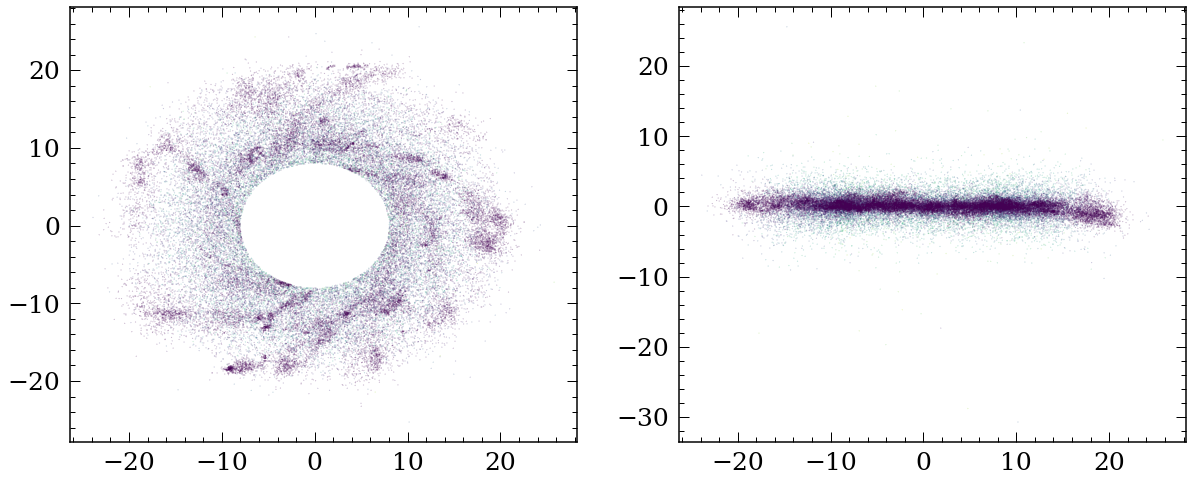

In [43]:
# stars that didn't migrate
m=abs(data['R']-data['R_bir'])<0.1
m=m&(data['R']>8)
print(sum(m)/len(data['R']))

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
#plt.scatter(data['x_today'],data['y_today'],s=0.01,c='k',alpha=0.05)
plt.scatter(data['x_today'][m],data['y_today'][m],s=0.01,c=data['age'][m],vmin=0,vmax=14)

plt.subplot(1,2,2)
#plt.scatter(data['R'],data['z'],s=0.01,c='k')
plt.scatter(data['x_today'][m],data['z'][m],s=0.01,c=data['age'][m],vmin=0,vmax=14)


## plot [Fe/H]-age

In [44]:
data_RbirR=data[m]

In [66]:
def makeagemap_each(R,z,R1,z1,lims,binnum):
    x1,x2,y1,y2 = lims[0], lims[1], lims[2], lims[3]
    
    R = np.array(R)
    z = np.array(z)

    R1 = np.array(R1)
    z1 = np.array(z1)
    
    xval = R
    yval = z
    
    xval1 = R1
    yval1 = z1
    
    x1m,x2m,y1m,y2m = lims[0], lims[1], lims[2], lims[3]
    
    hist1,x2,y2 = np.histogram2d(xval, yval, bins= binnum, range = ((x1m,x2m), (y1m,y2m)))
    hist2,x3,y3 = np.histogram2d(xval1, yval1, bins = binnum, range = ((x1m,x2m), (y1m,y2m)))

    image = (hist2)/hist1*100
    
    masked_array = np.ma.array (image, mask=np.isnan(image))
    
    return masked_array

<ipython-input-66-218085d5f10f>:21: RuntimeWarning: invalid value encountered in true_divide
  image = (hist2)/hist1*100


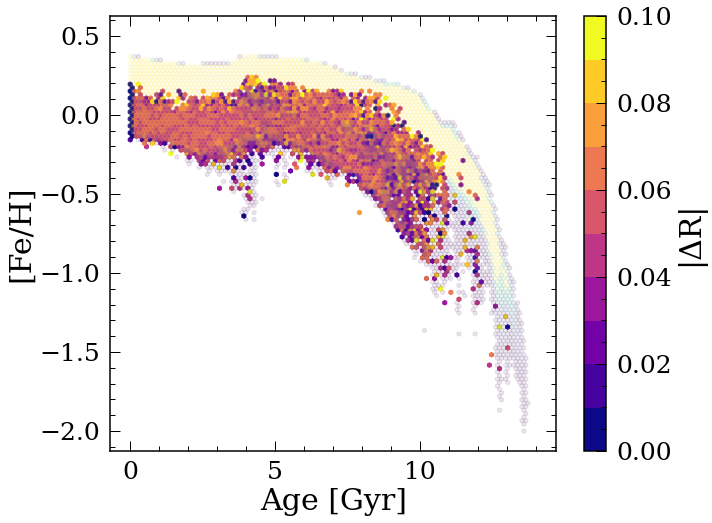

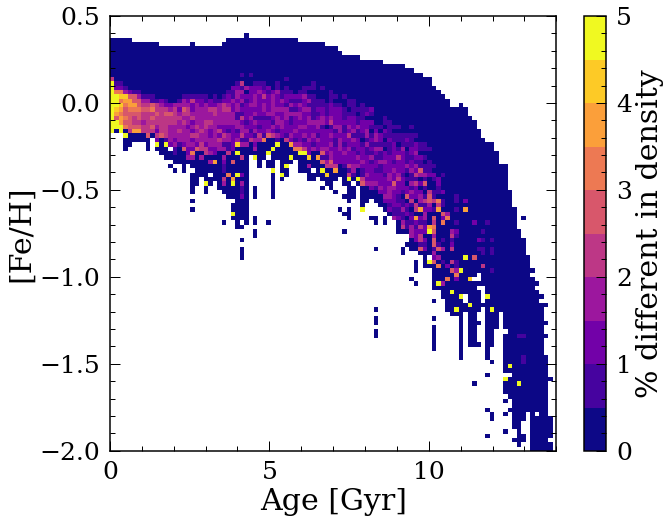

In [69]:
plt.figure(figsize=(10,8))
cmap = plt.get_cmap('plasma',10)
plt.hexbin(data_RbirR['age'],data_RbirR['feh_scale'],C=abs(data_RbirR['dR']),gridsize=100,
            extent=(0,14,-2,0.5),vmin=0,vmax=0.1,cmap=cmap)
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H]')
cb = plt.colorbar()
cb.set_label('|ΔR|')
plt.hexbin(data['age'],data['feh_scale'],gridsize=100,
           extent=(0,14,-2,0.5),vmin=0,vmax=1000,mincnt=10,alpha=0.1)



plt.figure(figsize=(10,8))
cmap = plt.get_cmap('plasma',10)
imgarr = makeagemap_each(data['age'],data['feh_scale'],data_RbirR['age'],data_RbirR['feh_scale'],
                        [0,14,-2,0.5],100)
plt.imshow(imgarr.T, interpolation="nearest" ,aspect = 'auto',origin = 'lower', 
           extent = (0,14,-2,0.5),cmap=cmap, vmin=0,vmax=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H]')
cb = plt.colorbar()
cb.set_label('% different in density')



<ipython-input-66-218085d5f10f>:21: RuntimeWarning: invalid value encountered in true_divide
  image = (hist2)/hist1*100


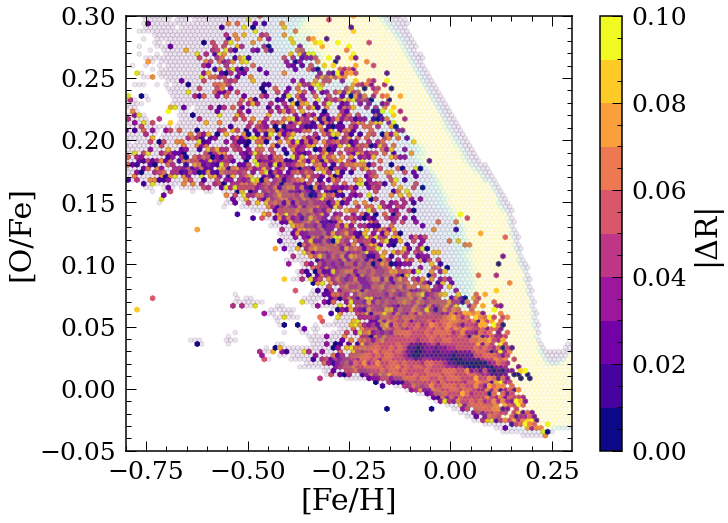

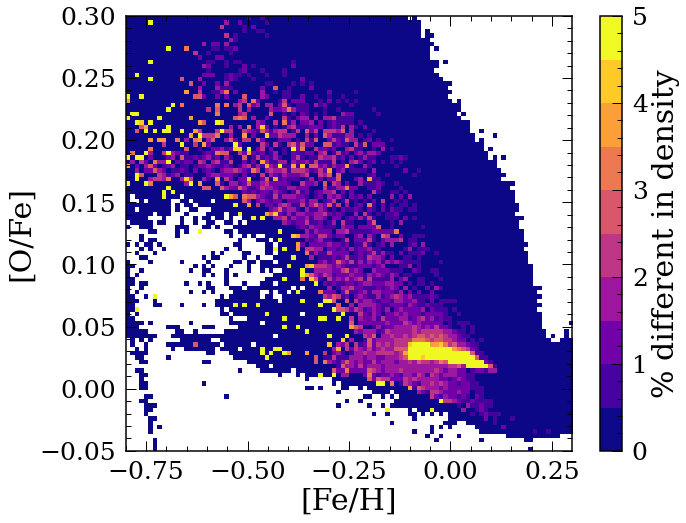

In [81]:
extents=(-0.8,0.3,-0.05,0.3)
plt.figure(figsize=(10,8))
cmap = plt.get_cmap('plasma',10)
plt.hexbin(data_RbirR['feh_scale'],data_RbirR['ofe_scale'],C=abs(data_RbirR['dR']),gridsize=100,
            extent=extents,vmin=0,vmax=0.1,cmap=cmap)
plt.xlabel('[Fe/H]')
plt.ylabel('[O/Fe]')
plt.xlim([extents[0],extents[1]])
plt.ylim([extents[2],extents[3]])
cb = plt.colorbar()
cb.set_label('|ΔR|')
plt.hexbin(data['feh_scale'],data['ofe_scale'],gridsize=100,
           extent=extents,vmin=0,vmax=1000,mincnt=10,alpha=0.1)



plt.figure(figsize=(10,8))
cmap = plt.get_cmap('plasma',10)
imgarr = makeagemap_each(data['feh_scale'],data['ofe_scale'],data_RbirR['feh_scale'],data_RbirR['ofe_scale'],
                        [extents[0],extents[1],extents[2],extents[3]],100)
plt.imshow(imgarr.T, interpolation="nearest" ,aspect = 'auto',origin = 'lower', 
           extent = extents,cmap=cmap, vmin=0,vmax=5)
plt.xlabel('[Fe/H]')
plt.ylabel('[O/Fe]')
plt.xlim([extents[0],extents[1]])
plt.ylim([extents[2],extents[3]])
cb = plt.colorbar()
cb.set_label('% different in density')




<ipython-input-66-218085d5f10f>:21: RuntimeWarning: invalid value encountered in true_divide
  image = (hist2)/hist1*100


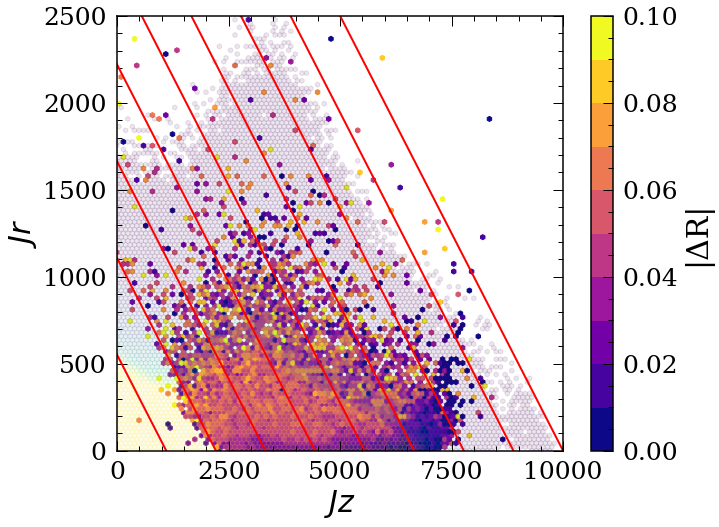

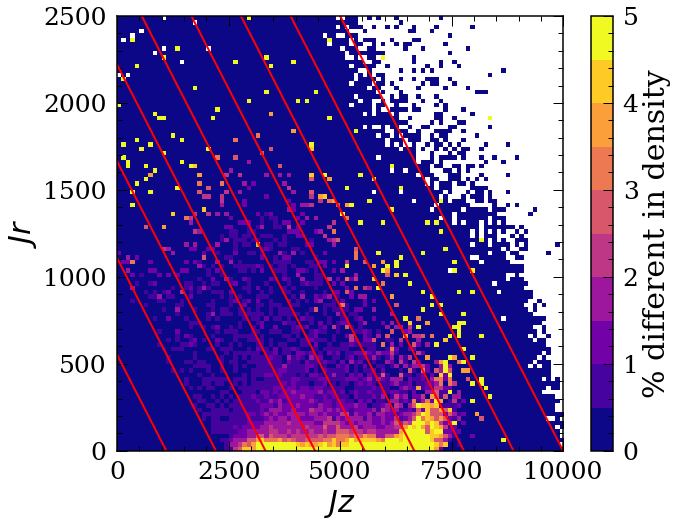

In [100]:
extents=(-10,10000,0,2500)
plt.figure(figsize=(10,8))
cmap = plt.get_cmap('plasma',10)
plt.hexbin(data_RbirR['Jz'],data_RbirR['Jr'],C=abs(data_RbirR['dR']),gridsize=100,
            extent=extents,vmin=0,vmax=0.1,cmap=cmap)
plt.xlabel('$Jz$')
plt.ylabel('$Jr$')
plt.xlim([extents[0],extents[1]])
plt.ylim([extents[2],extents[3]])
cb = plt.colorbar()
cb.set_label('|ΔR|')
plt.hexbin(data['Jz'],data['Jr'],gridsize=100,
           extent=extents,vmin=0,vmax=1000,mincnt=10,alpha=0.1)

jzstart=np.linspace(extents[0],extents[1],10)
for i in range(10):
    b = 0.5*jzstart[i]
    pltpointsx=[extents[0],extents[1]]
    plt.plot(pltpointsx,-0.5*np.array(pltpointsx)+b,'r-',label='LR')


plt.figure(figsize=(10,8))
cmap = plt.get_cmap('plasma',10)
imgarr = makeagemap_each(data['Jz'],data['Jr'],data_RbirR['Jz'],data_RbirR['Jr'],
                        [extents[0],extents[1],extents[2],extents[3]],100)
plt.imshow(imgarr.T, interpolation="nearest" ,aspect = 'auto',origin = 'lower', 
           extent = extents,cmap=cmap, vmin=0,vmax=5)
plt.xlim([extents[0],extents[1]])
plt.ylim([extents[2],extents[3]])
plt.xlabel('$Jz$')
plt.ylabel('$Jr$')
cb = plt.colorbar()
cb.set_label('% different in density')
jzstart=np.linspace(extents[0],extents[1],10)
for i in range(10):
    b = 0.5*jzstart[i]
    pltpointsx=[extents[0],extents[1]]
    plt.plot(pltpointsx,-0.5*np.array(pltpointsx)+b,'r-',label='LR')






<ipython-input-66-218085d5f10f>:21: RuntimeWarning: invalid value encountered in true_divide
  image = (hist2)/hist1*100


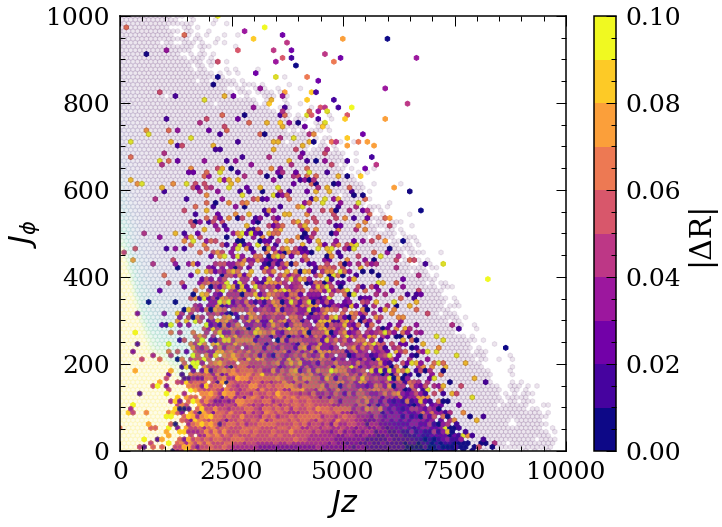

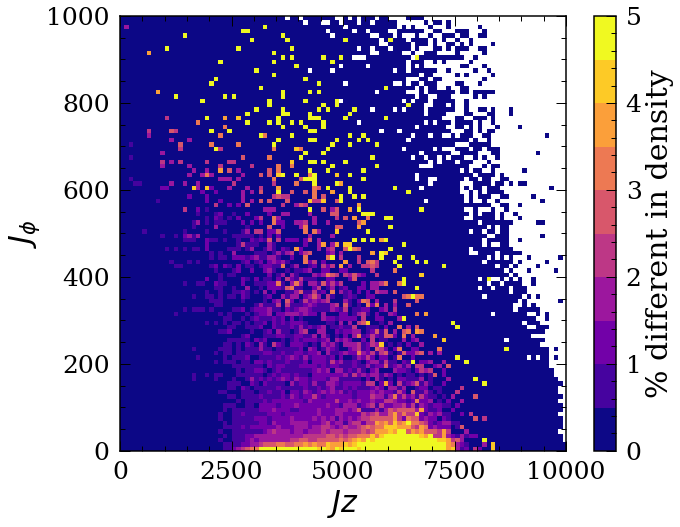

In [82]:
extents=(-10,10000,0,1000)
plt.figure(figsize=(10,8))
cmap = plt.get_cmap('plasma',10)
plt.hexbin(data_RbirR['Jz'],data_RbirR['Jphi'],C=abs(data_RbirR['dR']),gridsize=100,
            extent=extents,vmin=0,vmax=0.1,cmap=cmap)
plt.xlabel('$Jz$')
plt.ylabel('$J_{ϕ}$')
plt.xlim([extents[0],extents[1]])
plt.ylim([extents[2],extents[3]])
cb = plt.colorbar()
cb.set_label('|ΔR|')
plt.hexbin(data['Jz'],data['Jphi'],gridsize=100,
           extent=extents,vmin=0,vmax=1000,mincnt=10,alpha=0.1)



plt.figure(figsize=(10,8))
cmap = plt.get_cmap('plasma',10)
imgarr = makeagemap_each(data['Jz'],data['Jphi'],data_RbirR['Jz'],data_RbirR['Jphi'],
                        [extents[0],extents[1],extents[2],extents[3]],100)
plt.imshow(imgarr.T, interpolation="nearest" ,aspect = 'auto',origin = 'lower', 
           extent = extents,cmap=cmap, vmin=0,vmax=5)
plt.xlim([extents[0],extents[1]])
plt.ylim([extents[2],extents[3]])
plt.xlabel('$Jz$')
plt.ylabel('$J_{ϕ}$')
cb = plt.colorbar()
cb.set_label('% different in density')





<ipython-input-66-218085d5f10f>:21: RuntimeWarning: invalid value encountered in true_divide
  image = (hist2)/hist1*100


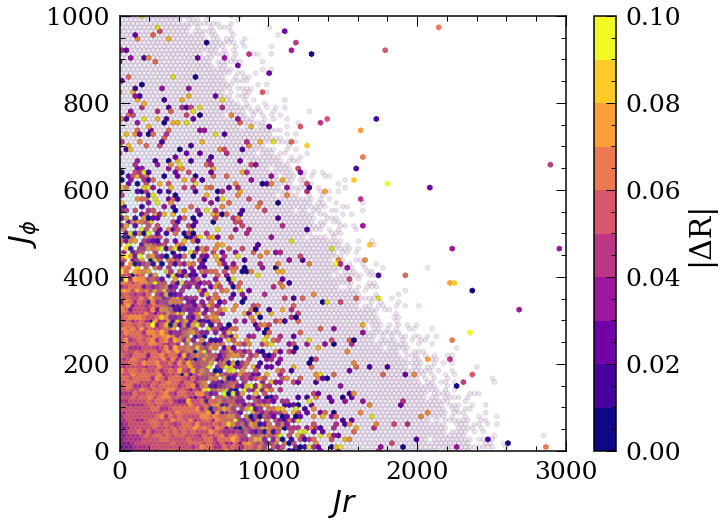

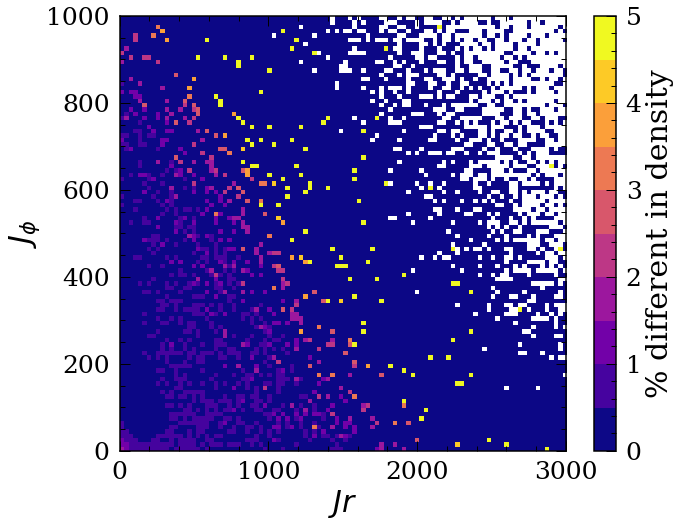

In [89]:
extents=(0,3000,0,1000)
plt.figure(figsize=(10,8))
cmap = plt.get_cmap('plasma',10)
plt.hexbin(data_RbirR['Jr'],data_RbirR['Jphi'],C=abs(data_RbirR['dR']),gridsize=100,
            extent=extents,vmin=0,vmax=0.1,cmap=cmap)
plt.xlabel('$Jr$')
plt.ylabel('$J_{ϕ}$')
plt.xlim([extents[0],extents[1]])
plt.ylim([extents[2],extents[3]])
cb = plt.colorbar()
cb.set_label('|ΔR|')
plt.hexbin(data['Jr'],data['Jphi'],gridsize=100,
           extent=extents,vmin=0,vmax=1000,mincnt=10,alpha=0.1)



plt.figure(figsize=(10,8))
cmap = plt.get_cmap('plasma',10)
imgarr = makeagemap_each(data['Jr'],data['Jphi'],data_RbirR['Jr'],data_RbirR['Jphi'],
                        [extents[0],extents[1],extents[2],extents[3]],100)
plt.imshow(imgarr.T, interpolation="nearest" ,aspect = 'auto',origin = 'lower', 
           extent = extents,cmap=cmap, vmin=0,vmax=5)
plt.xlim([extents[0],extents[1]])
plt.ylim([extents[2],extents[3]])
plt.xlabel('$Jr$')
plt.ylabel('$J_{ϕ}$')
cb = plt.colorbar()
cb.set_label('% different in density')






## check the AMR for astroseismic stars data

Text(0, 0.5, '[Fe/H]')

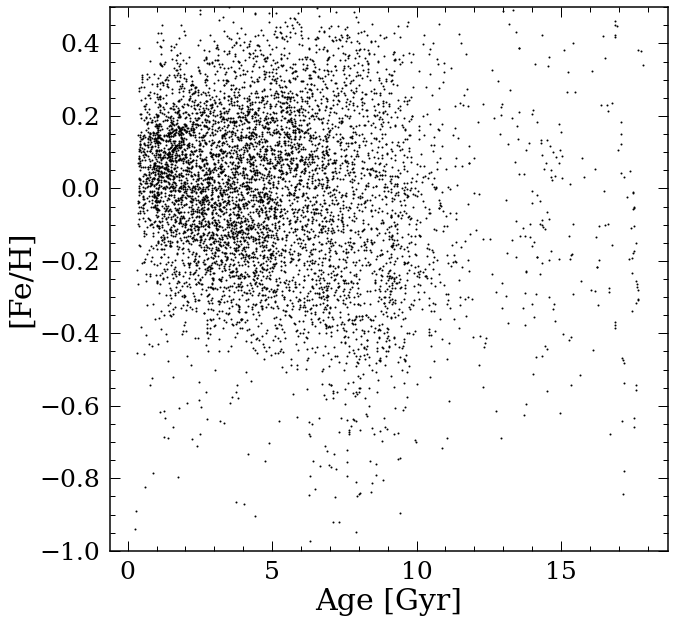

In [8]:
astro = pd.read_pickle('/Users/yl4331/Desktop/SecondYear/ASstars.pkl')
plt.scatter(astro['Age'],astro['FeH'],s=1,c='k')
plt.ylim([-1,0.5])
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H]')

## check the AMR for spectroscopy stars data

In [9]:
cannon = loaddata('age', agecode='ALL')
cannon

,l,b,age,feh,teff,logg,mg_fe,Dp,Dnu,dist,X,Y,z,R,hi_low,hi_low_1,hi_low_2
0,284.476737,-41.745171,5.211610,0.082355,4697.182295,2.426436,-0.001810,285.100576,4.358244,1278.417743,0.238449,0.923559,-0.851195,8.014940,False,False,False
1,284.606805,-42.060233,4.932221,0.131604,4696.066849,2.795849,0.013334,98.320984,7.805127,1580.880876,0.295991,1.135776,-1.059050,7.985195,False,False,False
2,284.730339,-41.816580,6.397169,-0.219007,4790.232370,2.828661,0.005019,12.083094,7.350019,1105.369886,0.209471,0.796737,-0.737003,8.030152,False,False,False
3,284.863342,-41.626043,10.584106,-0.124391,4717.903075,2.957076,0.144431,79.914720,10.003663,233.107942,0.044697,0.168417,-0.154846,8.157042,True,True,True
4,285.106830,-41.433692,6.120082,0.101547,4684.561446,2.829039,0.008014,86.163562,7.598573,827.965814,0.161778,0.599292,-0.547909,8.060531,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64312,71.302997,53.688896,8.832638,-0.443132,4717.135254,2.670065,0.323492,104.188622,7.457660,3444.676643,0.653896,-1.932184,2.775767,7.789546,True,True,True
64313,70.022028,53.531590,9.953266,-0.235772,4737.616211,2.752801,0.276022,69.679657,8.521639,2997.811095,0.608781,-1.674614,2.410794,7.773734,True,True,True
64314,70.364926,53.380059,8.249871,-0.018054,4547.682129,2.350973,0.048158,110.293007,3.087101,790.445304,0.158439,-0.444087,0.634419,8.053814,False,False,False
64315,71.794414,53.118904,8.648211,-0.510492,4762.442383,2.714240,0.370662,97.110769,7.536125,2524.655427,0.473386,-1.439340,2.019428,7.859533,True,True,True


In [21]:
def getbin(x,y,binnumb=100):
    xbin=np.linspace(min(x),max(x),binnumb)
    x_bin=((max(x)-min(x))/binnumb)/2+xbin[:-1]
    y_bin=np.zeros(len(x_bin))
    for i in range(len(x_bin)):
        m=(x>xbin[i])&(x<xbin[i+1])
        y_bin[i]=np.median(y[m])
    return x_bin, y_bin

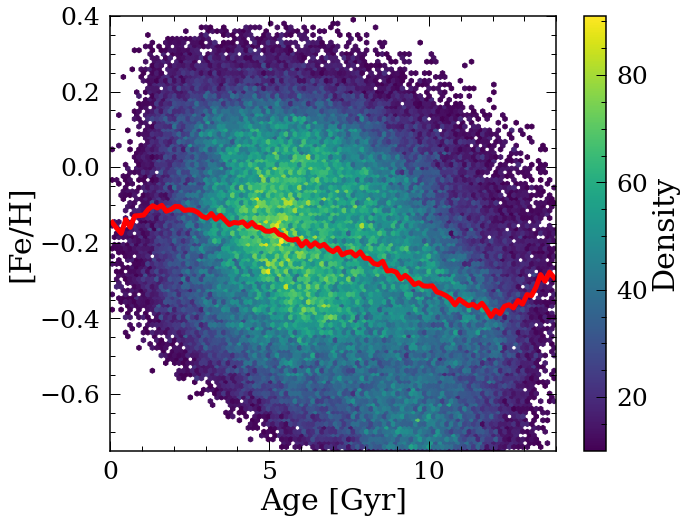

In [25]:
plt.figure(figsize=(10,8))
cannon = cannon.dropna(subset=['age','feh'])
cannon = cannon.loc[cannon['age']<14]
cannon = cannon.loc[(cannon['feh']>-0.75)&(cannon['feh']<0.4)]
plt.hexbin(cannon['age'],cannon['feh'],gridsize=100,mincnt=10,extent=(0,14,-0.75,0.4))
aveage, avefeh = getbin(cannon['age'],cannon['feh'],binnumb=100)
plt.plot(aveage, avefeh, 'r-', linewidth=5)
plt.ylim([-1,0.5])
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H]')
plt.xlim([0,14])
plt.ylim([-0.75,0.4])
cb = plt.colorbar()
cb.set_label('Density')

# check how much the [Fe/H] measurments in solar neighboorhood varies

In [6]:
import random
SolarRad = 8.2*(5./3.)
def get_SR(feh, x, y, radius=0.2*(5./3.), plotpoints=False):
    # radius: how big the solar circle is...
    
    # generate random location of the sun
    x_sun=random.uniform(-SolarRad, SolarRad)
    y_sun=np.sqrt(SolarRad**2.-x_sun**2.)*np.random.choice([-1,1])
    
    # get stars in the solar circle
    m=(((x-x_sun)**2.+(y-y_sun)**2.)<radius**2.)
    
    feh_sr, x_sr, y_sr = feh[m], x[m], y[m]
    
    r_sr=np.sqrt(x[m]**2. + y[m]**2.)
    
    if plotpoints:
        plt.figure()
        plt.plot(x,y,'k.',markersize=1)
        plt.plot(x_sr, y_sr,'r.',markersize=5)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        
    return feh_sr, r_sr, m

In [30]:
feh, x, y = data['feh_scale'], data['x_today'], data['y_today']
tryrun = 1000

allfeh = np.zeros(tryrun)
allfeh_std = np.zeros(tryrun)

sumfeh, totnum = 0, 0

for i in trange(tryrun):
    feh_sr, r, m = get_SR(feh, x, y)
    allfeh[i] = np.mean(feh_sr)
    
    sumfeh = sumfeh+sum(feh_sr)
    totnum = totnum+len(feh_sr)
    
    allfeh_std[i] = np.std(feh_sr)

100%|██████████| 1000/1000 [03:14<00:00,  5.15it/s]


Text(0.5, 0, 'std [Fe/H]')

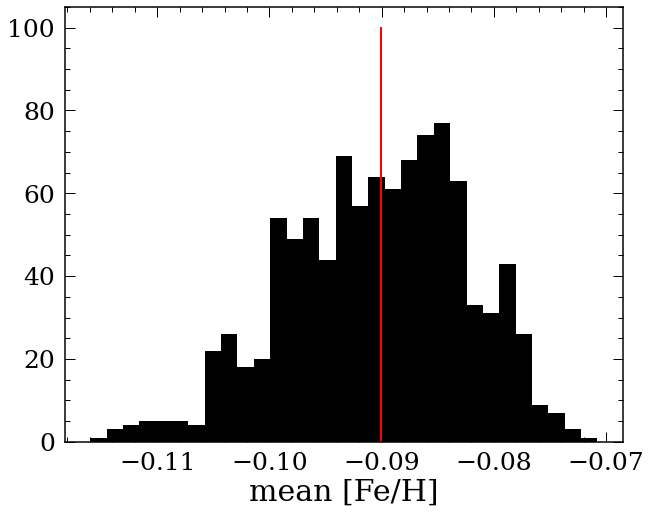

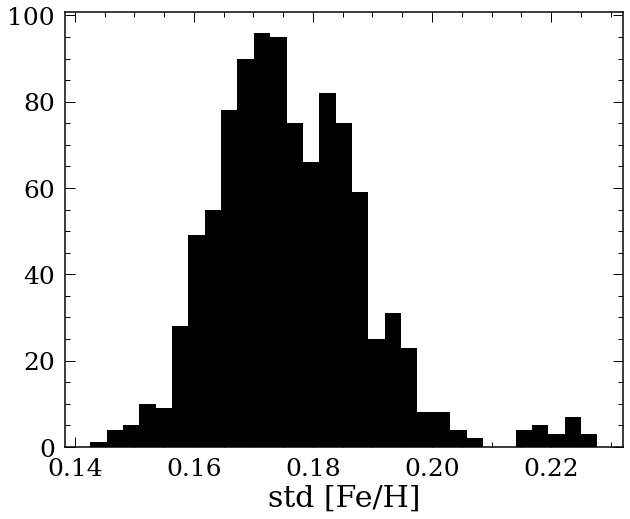

In [32]:
plt.figure(figsize=(10,8))
plt.hist(allfeh,bins=int(np.sqrt(len(allfeh))),color='k')
plt.plot([sumfeh/totnum, sumfeh/totnum], [0, 100], 'r-')
plt.xlabel('mean [Fe/H]')

plt.figure(figsize=(10,8))
plt.hist(allfeh_std,bins=int(np.sqrt(len(allfeh))),color='k')
plt.xlabel('std [Fe/H]')